In [4]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import os
import librosa
import wave
import matplotlib.pyplot as plt
import pywt
import seaborn as sns
from scipy.fftpack import fft
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation

print("Loaded libraries")

Loaded libraries


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def preprocess_audio(y, sr):
    # Down-sampling to a target rate (e.g., 16 kHz)
    target_sr = 16000
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # Quantization step (using 16-bit PCM range)
    y = np.int16(y * 32767)

    # Pre-emphasis filter to boost high frequencies
    pre_emphasis = 0.97
    y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # Framing and windowing (e.g., 25 ms frames with 10 ms overlap)
    frame_length = int(0.025 * sr)
    hop_length = int(0.01 * sr)
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    window = np.hanning(frame_length)
    framed_signal = frames * window[:, np.newaxis]

    # Fourier Transform (FFT)
    fft_signal = np.abs(fft(framed_signal, axis=0))

    # Wavelet Transform (using Discrete Wavelet Transform)
    coeffs, _ = pywt.dwt(y, 'db1')

    # Remove silence using librosa trim
    y, _ = librosa.effects.trim(y)

    # Normalize the audio
    y = librosa.util.normalize(y)

    # Signal trend removal
    y = y - np.mean(y)

    # Equalization (simple mean normalization)
    y = y / np.max(np.abs(y))

    return y

In [8]:
def extract_features(wav_file_name):
    y, sr = librosa.load(wav_file_name)
    y = preprocess_audio(y, sr)

    # Extracting MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

    # Extracting Chroma Features
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)

    # Extracting Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)

    # Extracting Zero-Crossing Rate
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)

    # Extracting RMS Energy
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)

    # Concatenate all features
    features = np.hstack([mfcc, chroma, spectral_contrast, zero_crossing_rate, rms])

    return features

In [9]:
# Visualize waveform and spectrogram
def plot_audio_features(y, sr):
    plt.figure(figsize=(10, 6))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # Extract and plot spectrogram
    plt.figure(figsize=(10, 6))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    # Extract MFCC and plot
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar()
    plt.title('MFCC')
    plt.show()

In [10]:
# Directory and file loading
ravdess_speech_labels = []
ravdess_speech_data = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/ML_Project_Dataset.zip (Unzipped Files)'):
    for filename in filenames:
        ravdess_speech_labels.append(int(filename[7:8]) - 1)
        wav_file_name = os.path.join(dirname, filename)
        ravdess_speech_data.append(extract_features(wav_file_name))

print("Finished loading the dataset")

Finished loading the dataset


In [11]:
# Convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data)
ravdess_speech_label_array = np.array(ravdess_speech_labels)

In [12]:
# Make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array)

x_train, x_test, y_train, y_test = train_test_split(np.array(ravdess_speech_data_array), labels_categorical, test_size=0.20, random_state=9)

In [13]:
# LSTM model creation
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(x_train.shape[1], 1)))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
w = np.expand_dims(ravdess_speech_data_array[:int(0.8 * len(ravdess_speech_data_array))], -1)

In [15]:
print (w)

[[[-3.18367682e+02]
  [-1.12078794e+01]
  [-1.30823486e+01]
  ...
  [ 1.94918525e+01]
  [ 2.15985365e-01]
  [ 5.58075793e-02]]

 [[-4.14913092e+02]
  [-6.25885552e+00]
  [-1.04805503e+01]
  ...
  [ 1.74220996e+01]
  [ 1.57813539e-01]
  [ 3.75701413e-02]]

 [[-2.79418313e+02]
  [ 6.40097841e+00]
  [-1.96094982e+01]
  ...
  [ 1.90737288e+01]
  [ 2.12944878e-01]
  [ 4.52226326e-02]]

 ...

 [[-3.81385509e+02]
  [-1.69872109e+01]
  [-1.12895103e+01]
  ...
  [ 1.84594796e+01]
  [ 2.55320143e-01]
  [ 3.36578898e-02]]

 [[-3.97690334e+02]
  [-1.59868829e+01]
  [-1.85319503e+01]
  ...
  [ 1.80864662e+01]
  [ 2.72083210e-01]
  [ 3.25778946e-02]]

 [[-4.16046108e+02]
  [-6.15388007e+00]
  [-2.08603878e+01]
  ...
  [ 1.78094945e+01]
  [ 2.26334951e-01]
  [ 2.98083946e-02]]]


In [16]:
# Train using LSTM model
model_A = create_model_LSTM()
history = model_A.fit(
    np.expand_dims(ravdess_speech_data_array[:int(0.8 * len(ravdess_speech_data_array))], -1),
    labels_categorical[:int(0.8 * len(ravdess_speech_data_array))],
    validation_data=(
        np.expand_dims(ravdess_speech_data_array[int(0.8 * len(ravdess_speech_data_array)):int(0.9 * len(ravdess_speech_data_array))], -1),
        labels_categorical[int(0.8 * len(ravdess_speech_data_array)):int(0.9 * len(ravdess_speech_data_array))]
    ),
    epochs=130,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.1389 - loss: 2.0904 - val_accuracy: 0.1458 - val_loss: 2.0729
Epoch 2/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.1159 - loss: 2.0771 - val_accuracy: 0.1597 - val_loss: 2.0702
Epoch 3/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.1097 - loss: 2.0704 - val_accuracy: 0.1076 - val_loss: 2.0702
Epoch 4/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1432 - loss: 2.0640 - val_accuracy: 0.1181 - val_loss: 2.0702
Epoch 5/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.1171 - loss: 2.0697 - val_accuracy: 0.1181 - val_loss: 2.0696
Epoch 6/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.1392 - loss: 2.0649 - val_accuracy: 0.1181 - val_loss: 2.0680
Epoch 7/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.1387 - loss: 2.0602 - val_accuracy: 0.1840 - val_loss: 2.0639
Epoch 8/130
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.1454 - loss: 2.0531 - val_accurac

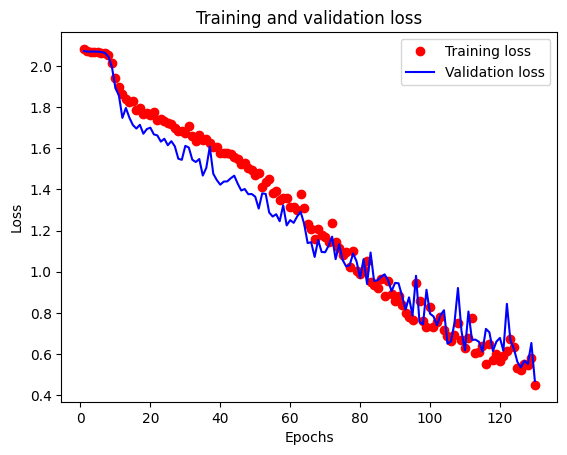

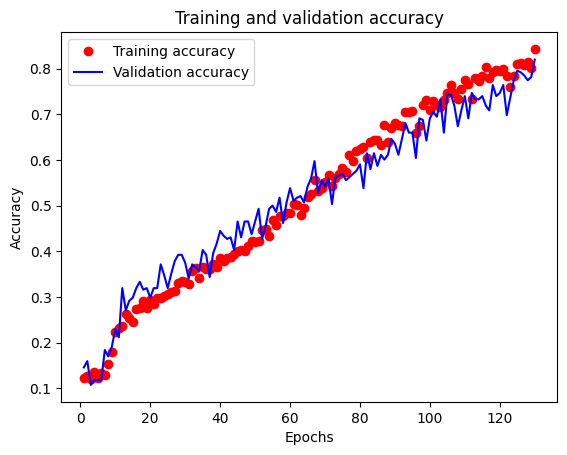

In [17]:

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Evaluate the model
model_A.evaluate(
    np.expand_dims(ravdess_speech_data_array[int(0.9 * len(ravdess_speech_data_array)):], -1),
    labels_categorical[int(0.9 * len(ravdess_speech_data_array)):]
)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8221 - loss: 0.5440


[0.470566064119339, 0.84375]

In [32]:
model_A = create_model_LSTM()
model_A.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,160 (301.41 KB)

 Trainable params: 77,160 (301.41 KB)

 Non-trainable params: 0 (0.00 B)

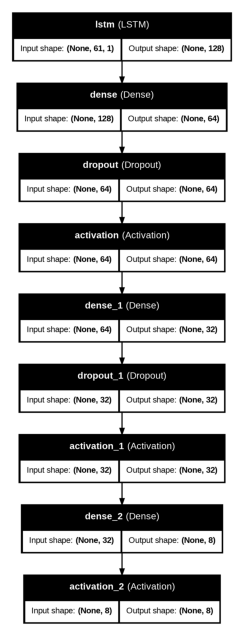

In [21]:
!pip install pydot
!pip install graphviz

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model # Import plot_model

# ... your existing code ...

# Visualize Model Architecture
plot_model(model_A, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [23]:
emotions = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}
def predict(wave_file_path):
    test_point = extract_features(wave_file_path)
    test_point = np.expand_dims(test_point, axis=0)
    test_point = np.expand_dims(test_point, axis=-1)
    prediction = model_A.predict(test_point)
    predicted_emotion = np.argmax(prediction)
    return emotions[predicted_emotion]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       0.42      0.31      0.36        16
        calm       0.76      0.88      0.82        33
       happy       0.85      0.85      0.85        39
         sad       0.80      0.90      0.85        40
       angry       0.92      0.85      0.88        40
     fearful       0.94      0.82      0.88        40
     disgust       0.80      0.93      0.86        40
   surprised       1.00      0.90      0.95        40

    accuracy                           0.84       288
   macro avg       0.81      0.80      0.80       288
weighted avg       0.85      0.84      0.84       288



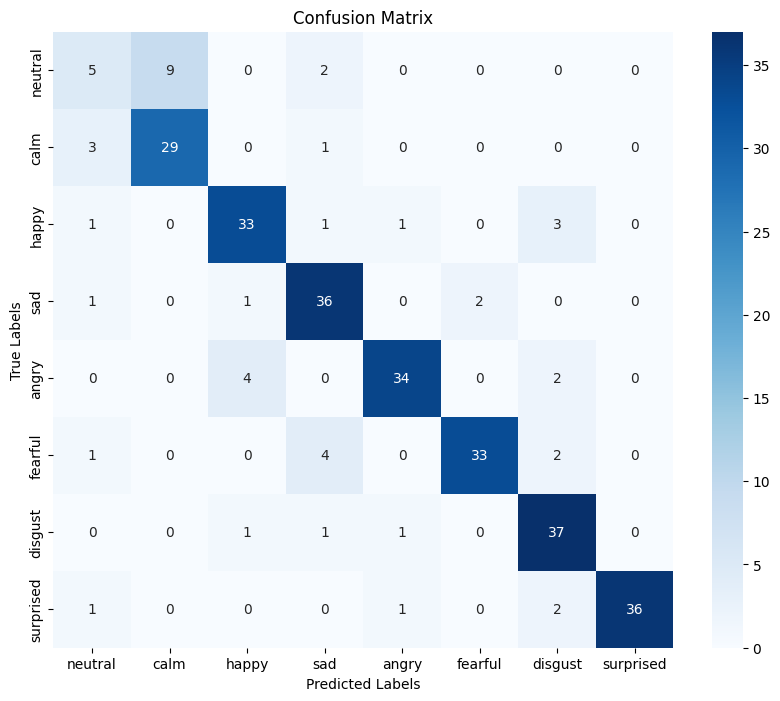

In [24]:
# Classification report and confusion matrix
y_pred = model_A.predict(np.expand_dims(ravdess_speech_data_array[int(0.9 * len(ravdess_speech_data_array)):], -1))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(labels_categorical[int(0.9 * len(ravdess_speech_data_array)):], axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[emotions[i+1] for i in range(len(emotions))]))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=[emotions[i+1] for i in range(len(emotions))], yticklabels=[emotions[i+1] for i in range(len(emotions))])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

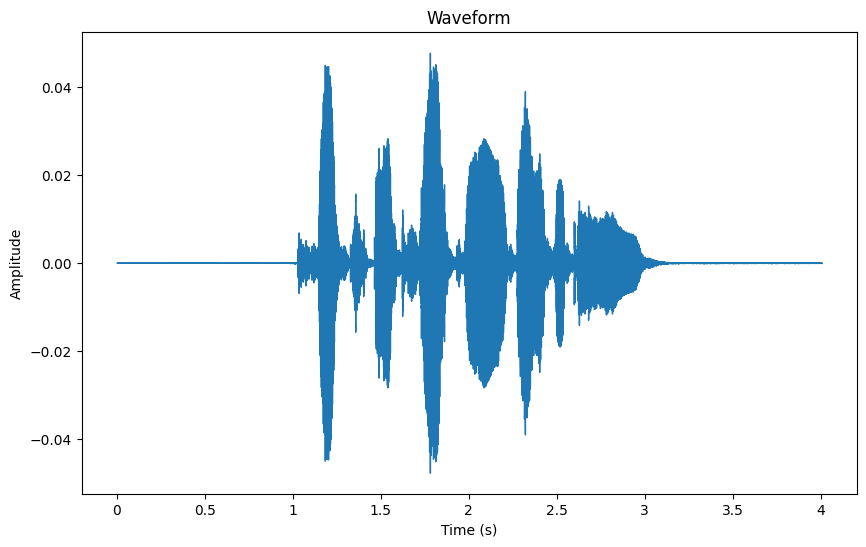

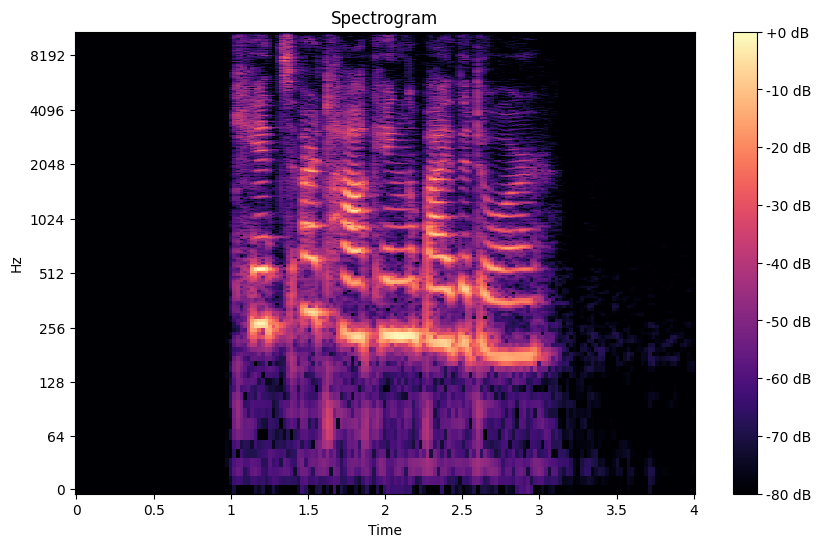

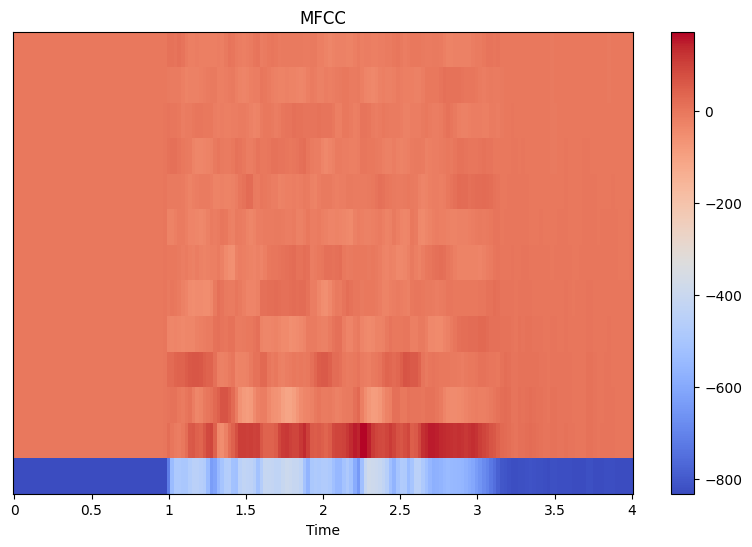

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Predicted Emotion:  neutral


In [29]:
# Example to visualize audio features and make prediction
y, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/ML_Project_Dataset.zip (Unzipped Files)/Actor_02/03-01-02-01-01-02-02.wav')
plot_audio_features(y, sr)
print("Predicted Emotion: ", predict('/content/drive/MyDrive/Colab Notebooks/ML_Project_Dataset.zip (Unzipped Files)/Actor_02/03-01-02-01-01-02-02.wav'))

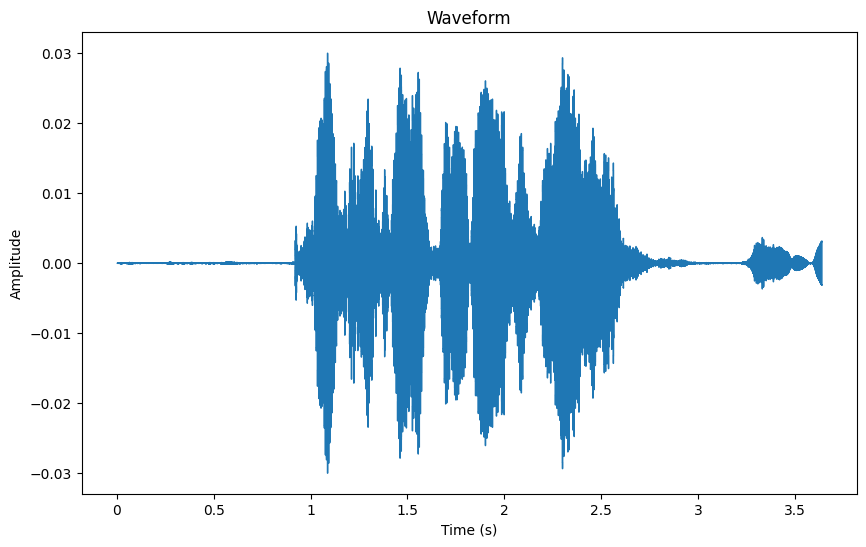

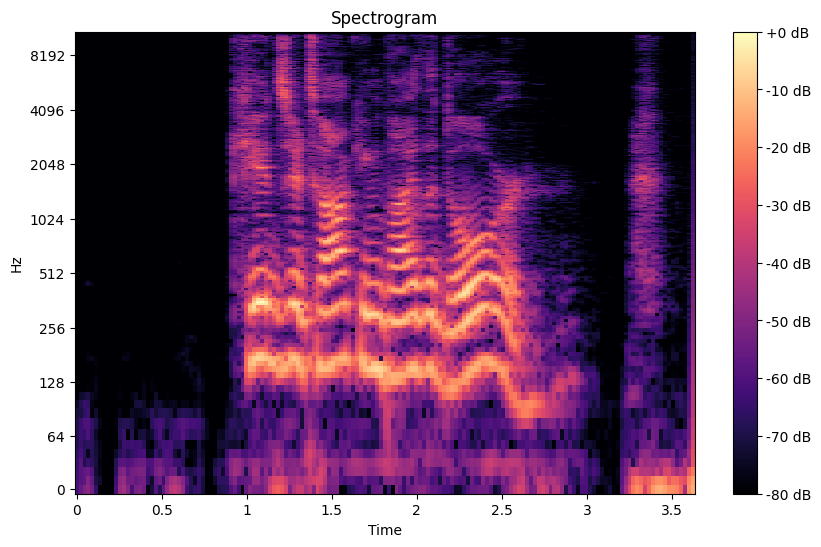

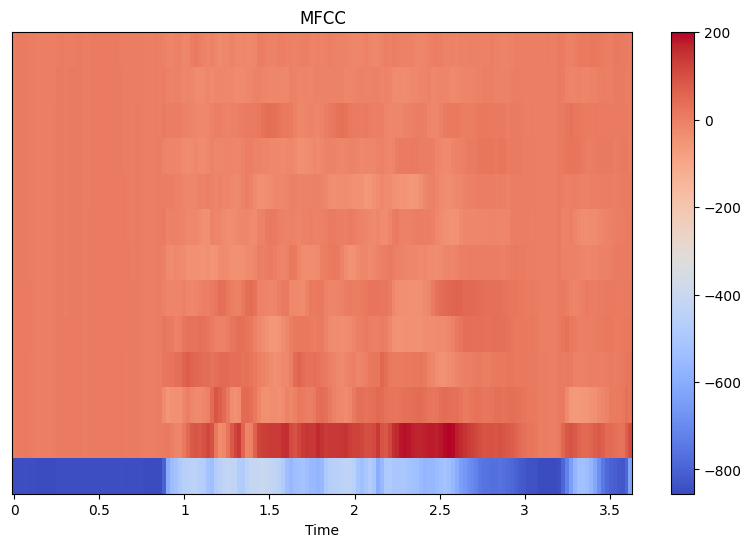

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Emotion:  calm


In [31]:
# Example to visualize audio features and make prediction
y, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/ML_Project_Dataset.zip (Unzipped Files)/Actor_19/03-01-03-01-01-01-19.wav')
plot_audio_features(y, sr)
print("Predicted Emotion: ", predict('/content/drive/MyDrive/Colab Notebooks/ML_Project_Dataset.zip (Unzipped Files)/Actor_19/03-01-03-01-01-01-19.wav'))